In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder =  "/Users/simon/Documents/DTU fag/Speciale/vejle_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);
VV = _load_jld(VV_files[[1,4]],data_folder);
VH = _load_jld(VH_files[[1,4]],data_folder);

In [2]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/vejle_new/flood"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_ham.jld"),"data")]

VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VH_pre_ham.jld"),"data")];

In [3]:
threshold_indx = 3

3

## VV

In [4]:
co = VV[1][:,end:-1:1]
pre = VV[2][:,end:-1:1];

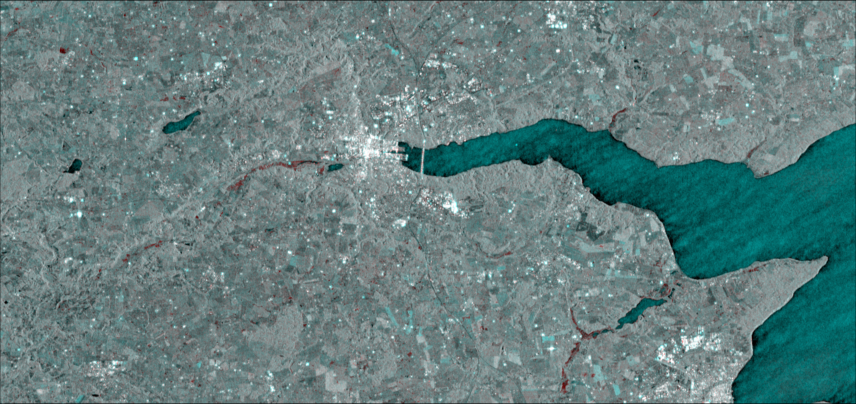

In [5]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [6]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [7]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


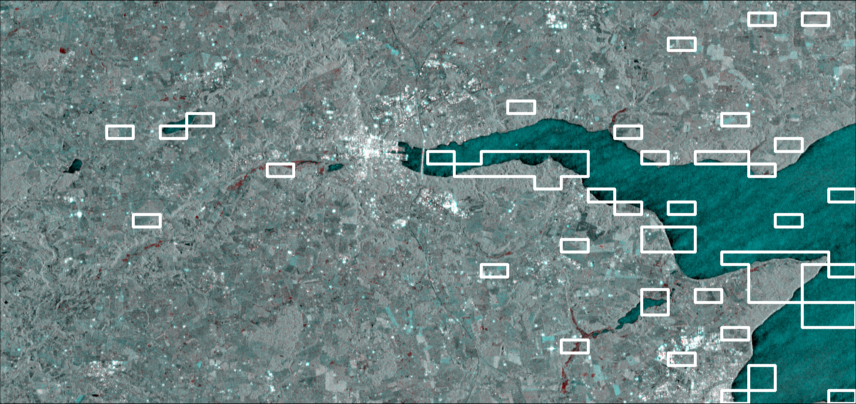

In [8]:
subset_edges = get_edges(bm_mask);
add_mask(imgVV,subset_edges,(1,1,1))

In [10]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;



In [11]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-11.675, -1.0], f_i: 0.0011756428381357671
dfdx: [0.0, 0.0]

Iterration : 2
x_i: [-11.675, -1.0], f_i: 0.0011756428381357671
dfdx: [0.0, 0.0]

Iterration : 3
x_i: [-11.675, -1.0], f_i: 0.0011756428381357671
dfdx: [-5.77679e-6, -9.15581e-6]
Step x, step_idx:4,  no_step: -2

Iterration : 4
x_i: [-11.0973, -0.0844193], f_i: 0.0011104893800638225
dfdx: [-4.70972e-5, -9.58584e-5]
Step x, step_idx:3,  no_step: -2

Iterration : 5
x_i: [-10.6263, 0.874164], f_i: 0.0008805179825685272
dfdx: [-0.00014127, -0.000228086]
Step x, step_idx:3,  no_step: -2

Iterration : 6
x_i: [-9.21365, 3.15502], f_i: 0.0004868934065118491
dfdx: [1.69598e-6, -4.43486e-5]
Step x, step_idx:5,  no_step: -2

Iterration : 7
x_i: [-10.9096, 47.5036], f_i: 0.00032001390638483764
dfdx: [1.40248e-7, -4.32775e-6]
Step x, step_idx:3,  no_step: -2

Iterration : 8
x_i: [-10.911, 47.5469], f_i: 0.0003199351859135722
dfdx: [1.40248e-7, -4.32815e-7]
Step x, step_idx:3,  no_step: -2

Iterration : 9
x_i: [-10.91

In [ ]:
 thresholds3, f3

In [12]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([1.2818, 1.38866], 0.000587359689774592)

In [13]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-10.0761, 1.99879], 0.0005042300232626187)

In [14]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [15]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [16]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

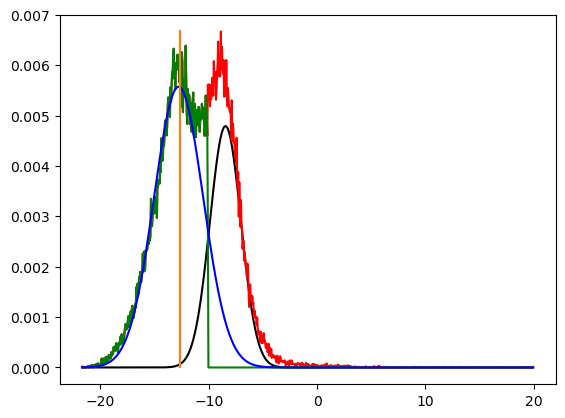

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1488b8710>

In [17]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
#PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

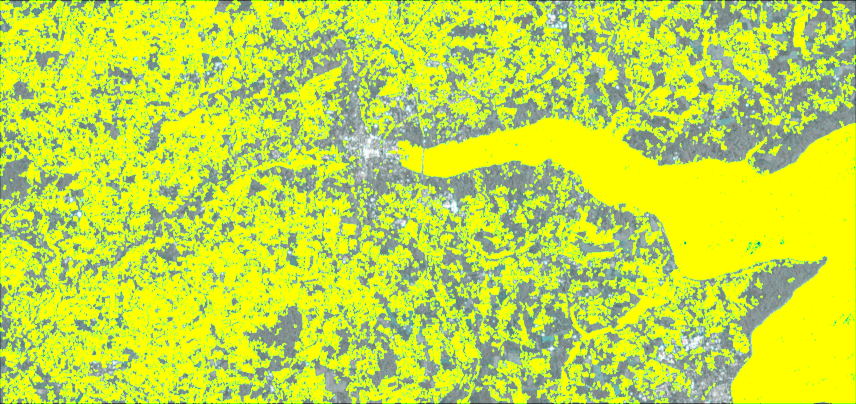

In [18]:
add_mask(imgVV,flood_mask,(1,2,0))

In [19]:
rg_thresholds

2-element Array{Float64,1}:
 -10.076012706413268
  47.55130224392476 

In [20]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

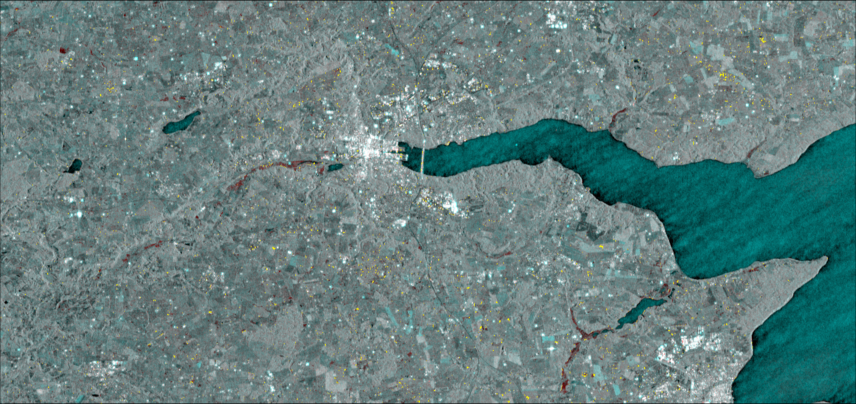

In [21]:
add_mask(imgVV,final_mask,(1,1,0))

## VH

In [22]:
co = VH[1][:,end:-1:1]
pre = VH[2][:,end:-1:1];

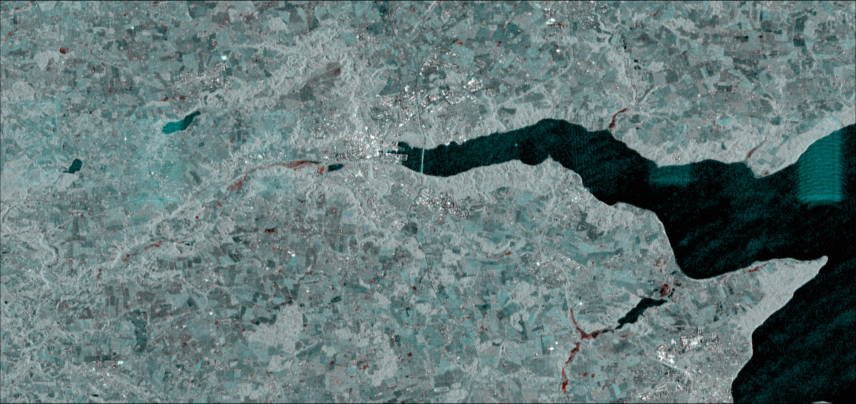

In [23]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [24]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [25]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


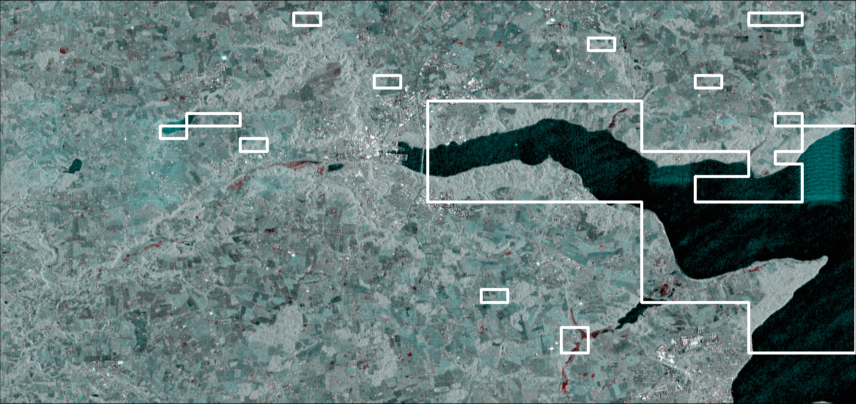

In [26]:
subset_edges = get_edges(bm_mask);
add_mask(imgVH,subset_edges,(1,1,1))

In [27]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;

In [28]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3)


Iterration : 1
x_i: [-23.625, -1.0], f_i: 6.18355402527681e-5
dfdx: [0.0, 0.0]

Iterration : 2
x_i: [-23.625, -1.0], f_i: 6.18355402527681e-5
dfdx: [0.0, 0.0]

Iterration : 3
x_i: [-23.625, -1.0], f_i: 6.18355402527681e-5
dfdx: [-2.87311e-7, -1.48305e-7]
Step x, step_idx:5,  no_step: -2

Iterration : 4
x_i: [-23.3377, -0.851695], f_i: 6.160393364255538e-5
dfdx: [-6.25751e-7, -3.67994e-7]
Step x, step_idx:5,  no_step: -2

Iterration : 5
x_i: [-22.7119, -0.483701], f_i: 6.125639819519624e-5
dfdx: [-2.65115e-7, -4.4732e-7]
Step x, step_idx:5,  no_step: -2

Iterration : 6
x_i: [-22.4468, -0.0363814], f_i: 6.109771333205194e-5
dfdx: [-7.7247e-8, -2.96745e-6]
Step x, step_idx:5,  no_step: -2

Iterration : 7
x_i: [-22.3696, 2.93107], f_i: 5.869956329970715e-5
dfdx: [7.3846e-7, -2.96002e-7]
Step x, step_idx:5,  no_step: -2

Iterration : 8
x_i: [-23.108, 3.22707], f_i: 5.8382094063900675e-5
dfdx: [8.20089e-7, -2.99976e-8]
No change, Decrease delta, no_step: -1

Iterration : 9
x_i: [-23.108, 3.

5.794027070975674e-5

In [29]:
thresholds3, f3

([-22.3059, 3.2571], 5.794027070975674e-5)

In [30]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([11.7375, -0.525], 6.141073274660923e-5)

In [31]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-22.9247, 1.99752], 5.978064384921139e-5)

In [32]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx]

2-element Array{Float64,1}:
 -22.305887926708063
   3.25709765556515 

In [33]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [34]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

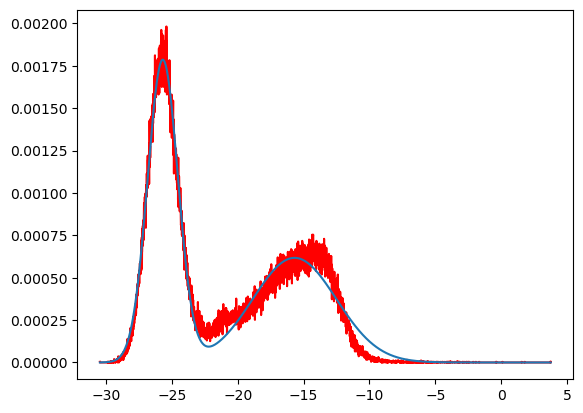

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x148f4ff98>

In [35]:
PyPlot.figure()
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )


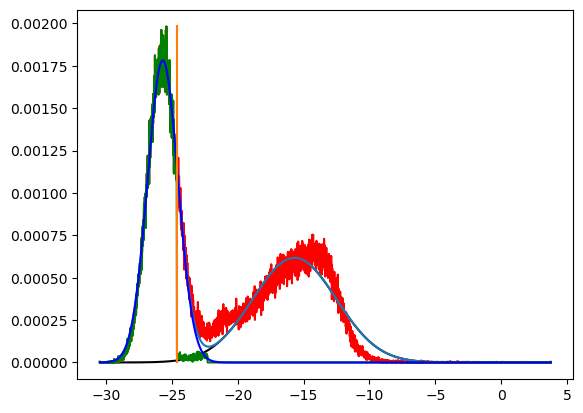

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13d4cc780>

In [36]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

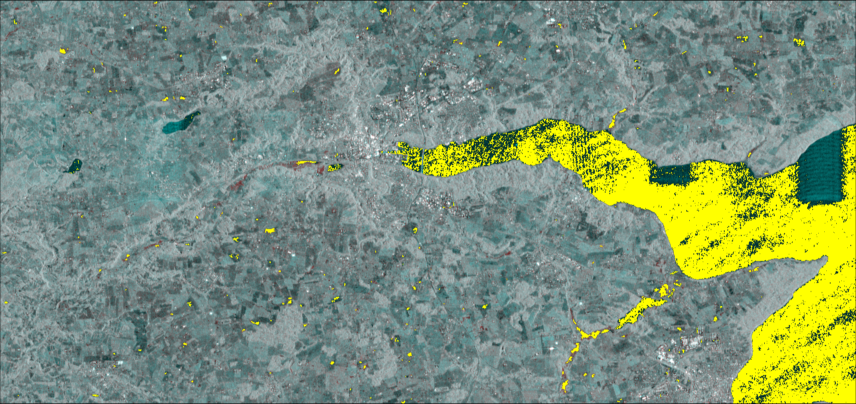

In [37]:
add_mask(imgVH,flood_mask,(1,1,0))

In [38]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

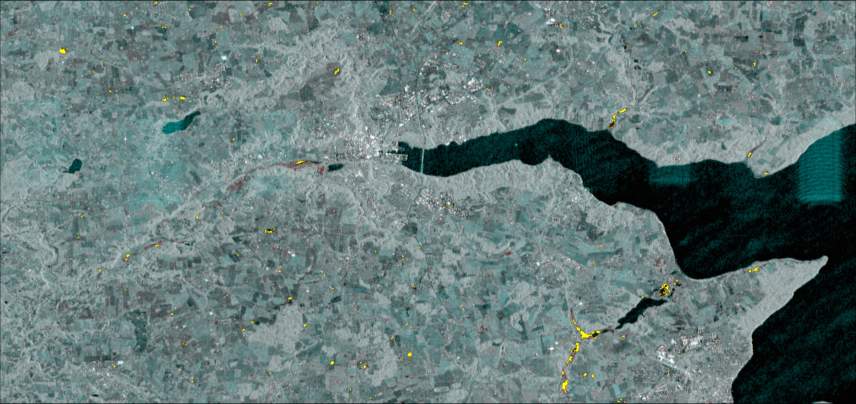

In [39]:
add_mask(imgVH,final_mask,(1,1,0))